In [1]:
library("dplyr")
library("sf")
library("sfnetworks")
library("tidygraph")
library("osmdata")


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“il pacchetto ‘sf’ è stato creato con R versione 4.3.2”
Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Warning message:
“il pacchetto ‘sfnetworks’ è stato creato con R versione 4.3.2”
Warning message:
“il pacchetto ‘tidygraph’ è stato creato con R versione 4.3.2”

Caricamento pacchetto: ‘tidygraph’


Il seguente oggetto è mascherato da ‘package:stats’:

    filter


Data (c) OpenStreetMap contributors, ODbL 1.0. https://www.openstreetmap.org/copyright



# Corridor edges

In this notebooks we explore how to delineate river corridor edges using Bucharest as the study area.

## 1. Initial corridor edge

While ideally we want to base the initial estimate of the corridor edge on the basis of the river valley delineation, we use here the roughest approach of defining a buffer region (500 m) around the waterways. This method could actually be the method of choice for flat cities. 

We get waterway data from OSM via the Overpass API, using the `osmdata` package. We define our area of interest (AoI): 

In [2]:
bb <- getbb("Bucharest")

We use `osmdata`'s Overpass query functionality (`opq()`) to search for the waterways in the AoI:

In [15]:
osmdata_as_sf <- function(key, value, bb){
    bb |>
        opq() |>
        add_osm_feature(key = key, value = value) |>
        osmdata_sf()
}

In [16]:
waterways_osm_key <- "waterway" 
waterways_osm_value <- c("river", "canal")
waterways <- osmdata_as_sf(
    waterways_osm_key,
    waterways_osm_value,
    bb
)

**NOTE**: the tags above return linestrings corresponding to the rivers. Maybe it could actually be better to use polygons got from [key:water](https://wiki.openstreetmap.org/wiki/Key:water) instead? 

Lines are clustered by rivers' name in multilines:

In [17]:
waterways$osm_multilines

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,osm_id,name,role,destination,type,waterway,wikidata,wikipedia,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<MULTILINESTRING [°]>
6213642-(no role),6213642,Pasărea,(no role),Dâmbovița,waterway,river,Q7143173,"ro:Râul Pasărea, Dâmbovița",MULTILINESTRING ((26.01958 ...
6213935-(no role),6213935,Dâmbovița,(no role),,waterway,river,Q214646,ro:Râul Dâmbovița,MULTILINESTRING ((24.95921 ...
6214017-(no role),6214017,Colentina,(no role),Dâmbovița,waterway,river,Q1108116,ro:Râul Colentina,MULTILINESTRING ((25.65092 ...


We transform the rivers to a projected CRS suitable for the AoI:

In [38]:
epsg_code <- 32635  # UTM zone 35N
waterways_transformed <- waterways$osm_multilines |>
    st_transform(epsg_code)

We then construct the initial corridor edge as a buffer region around the waterways:

In [31]:
buffer <- 500
waterways_buffer <- waterways_transformed |>
    st_buffer(buffer)

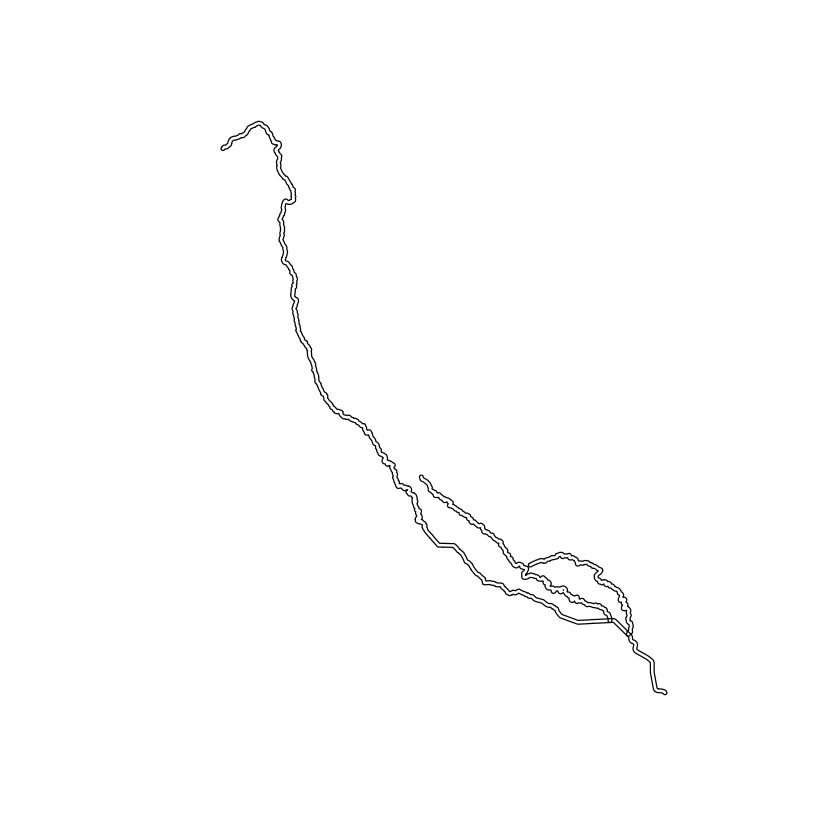

In [32]:
waterways_buffer |>
    st_geometry() |>
    plot()

## 2. Street network

We use `sfnetworks` to setup the street network based on OSM data, mostly following [this tutorial](https://geospatial-community.netlify.app/post/2022-03-31-spatial-networks/) for data cleaning and network setup.

Similarly to the previous step, we download the street data from OSM using the Overpass API:

In [40]:
highways_osm_key <- "highway" 
highways_osm_value <- c("motorway", "primary", "secondary", "tertiary")
highways <- osmdata_as_sf(
    highways_osm_key,
    highways_osm_value,
    bb
)

In [41]:
highways_lines <- highways$osm_lines

We convert the highways that are returned as polygons to linestrings, and add them to the dataframe: 

In [42]:
poly_to_lines <- highways$osm_polygons |>
    st_cast("LINESTRING")
highways_lines <- highways_lines |>
    bind_rows(poly_to_lines)

Warning message in st_cast.sf(highways$osm_polygons, "LINESTRING"):
“repeating attributes for all sub-geometries for which they may not be constant”


Create the network object and convert it to a projected CRS: 

In [43]:
net <- highways_lines |> 
    as_sfnetwork(directed = FALSE) |>
    st_transform(epsg_code)

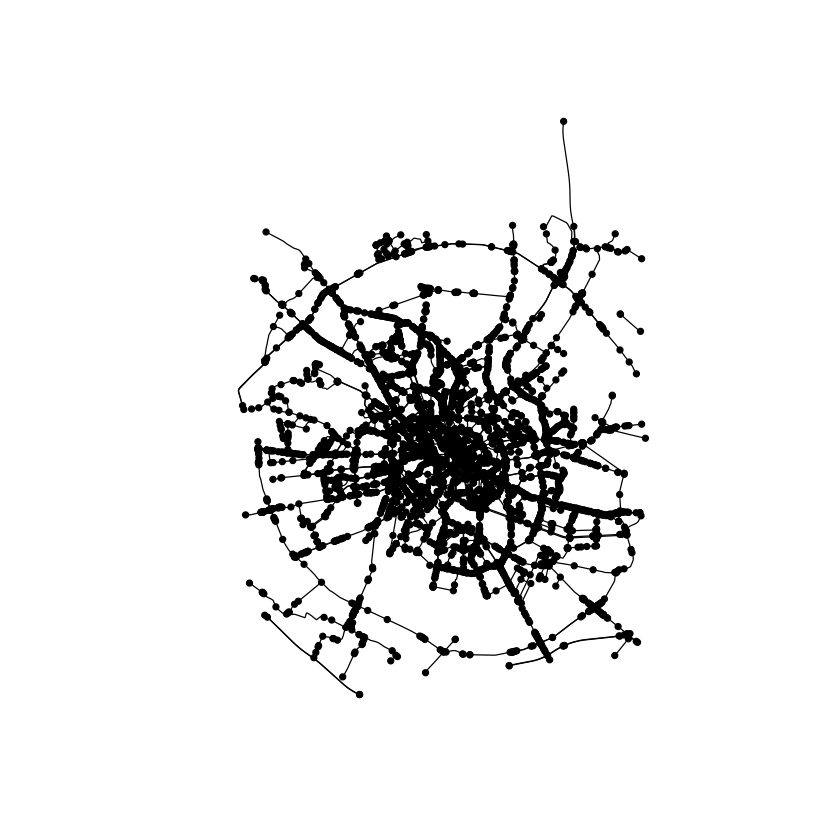

In [44]:
plot(net)

## 3. Corridor edge delineation

Let's start with only one of the rivers, e.g. the Dâmbovița:

In [47]:
waterway <- waterways_buffer |> 
    filter(name == "Dâmbovița")

Let's also convert the bounding box of the city into a polygon, using the same projected CRS:

In [128]:
bbox <- bb |> as.vector() 
names(bbox) <- c("xmin", "ymin", "xmax", "ymax")
poly <- bbox |> 
    st_bbox(crs = st_crs(4326)) |>
    st_as_sfc() |>
    st_transform(crs = st_crs(epsg_code)) |>
    st_bbox() |>
    st_as_sfc()

Visualize the elements:

Warning message in plot.sf(waterway, col = "red", add = TRUE):
“ignoring all but the first attribute”


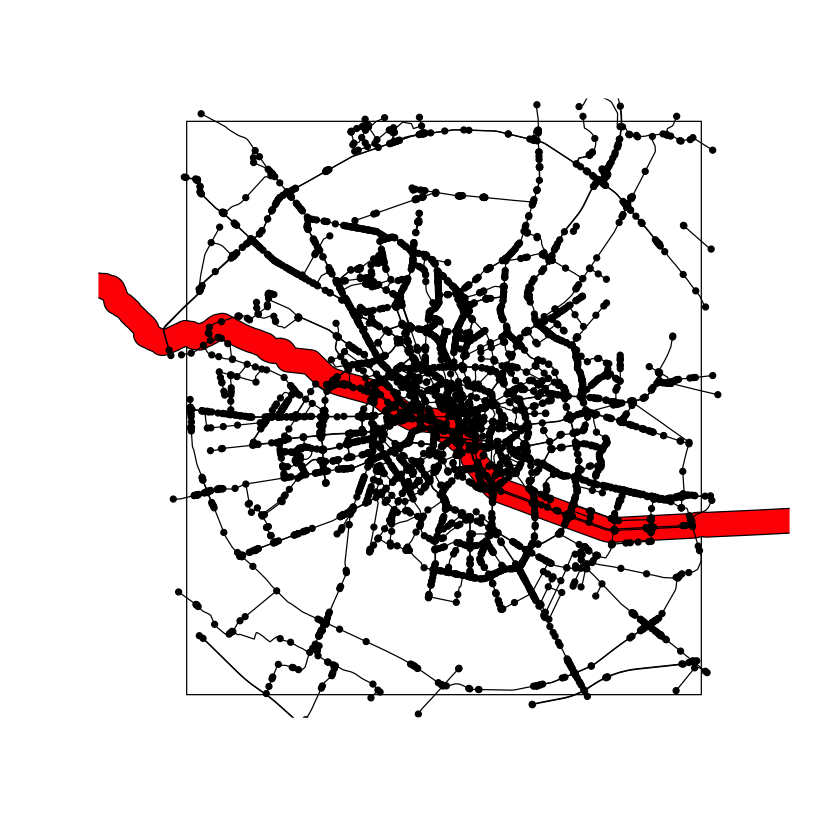

In [176]:
poly |> st_geometry() |> plot()
plot(waterway, col = "red", add = TRUE)
plot(net, add = TRUE)